In [8]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
from scipy.stats import chi2_contingency, f_oneway

import datetime
import calendar
import math

cmap = cm.get_cmap('gnuplot')
pd.set_option('display.max_columns', None)


In [2]:
# dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
# IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

In [3]:
# train_upsampled = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/final_train_NI.csv")
# test = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/final_test_NI.csv")

In [9]:

dataset = pd.read_csv('Fraud_Data.csv')
IP_table = pd.read_csv('IpAddress_to_Country.csv')

train_upsampled = pd.read_csv("final_train_NI.csv")
test = pd.read_csv("final_test_NI.csv")


In [10]:
X_train_upsampled = train_upsampled.iloc[:,:len(train_upsampled.columns)-1]
y_train_upsampled = train_upsampled.iloc[:,-1:]

X_test = test.iloc[:,:len(test.columns)-1]
y_test = test.iloc[:,-1:]

In [11]:
y_train_upsampled.value_counts()

class
0        95892
1        95892
dtype: int64

In [13]:
scaler = StandardScaler() 
stand = scaler.fit(X_train_upsampled)
X_train_scaled = pd.DataFrame(stand.transform(X_train_upsampled), columns = X_train_upsampled.columns.tolist())
X_test_scaled = pd.DataFrame(stand.transform(X_test), columns =  X_test.columns.tolist())
print(pd.DataFrame(X_train_scaled).describe())
print(pd.DataFrame(X_test_scaled).describe())

       countries_from_device  quick_purchase    source_Ads  source_Direct  \
count           1.917840e+05    1.917840e+05  1.917840e+05   1.917840e+05   
mean            8.536116e-17   -4.268058e-17 -2.415602e-17  -1.163342e-17   
std             1.000003e+00    1.000003e+00  1.000003e+00   1.000003e+00   
min            -3.516858e-01   -6.062358e-01 -8.085583e-01  -5.211931e-01   
25%            -3.516858e-01   -6.062358e-01 -8.085583e-01  -5.211931e-01   
50%            -3.516858e-01   -6.062358e-01 -8.085583e-01  -5.211931e-01   
75%            -3.516858e-01    1.649523e+00  1.236769e+00  -5.211931e-01   
max             8.930536e+00    1.649523e+00  1.236769e+00   1.918675e+00   

         source_SEO  browser_Chrome  browser_FireFox    browser_IE  \
count  1.917840e+05    1.917840e+05     1.917840e+05  1.917840e+05   
mean  -5.409171e-18   -1.904324e-17     4.645959e-17 -2.178488e-17   
std    1.000003e+00    1.000003e+00     1.000003e+00  1.000003e+00   
min   -8.013808e-01   -8.4

In [7]:
dataset["time"] = pd.DataFrame(pd.to_datetime(dataset["purchase_time"]) - pd.to_datetime(dataset["signup_time"])).astype(str)
dataset["time"] = dataset["time"].apply(lambda x : x[-8:])
dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
dataset["time"]

0         03:51:22
1         04:59:04
2         00:00:01
3         16:41:25
4         11:31:01
            ...   
151107    21:27:13
151108    18:41:10
151109    08:00:16
151110    13:28:39
151111    19:01:33
Name: time, Length: 151112, dtype: object

In [8]:
device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)

In [9]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [10]:
dataset = dataset.merge(device_duplicates, on= "device_id")

# --- 1 ---
# Categorisation column freq_device
# We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
dataset.freq_device = dataset.freq_device.apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# We add features 

# --- 2 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# --- 6 ---
# Column countries_from_device (ie. number of different countries per device_id)

# We flag devices that committed purchases from different countries
# First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# --- 7 ---
# Column risk_country which classifies each country based on historical fraud rate from these countries

# We calculate the proportion of fraud by country
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# We classify each country between Very High risk, High risk, Medium risk and low risk
risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")
                                                
# We merge with dataset
dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# --- 8 ---
# Column "quick_purchase" : categorise time between sign_up and purchase
dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# --- 9 ---
# Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# We merge it with a DF containing purchase_value and device_id
duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# We categorise number of time the same purchase has been made 
duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )
                                            
# We merge the result with main dataset            
dataset = dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# --- 10 ---- 
# age categorisation

dataset["age_category"] = dataset.age.apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

# ---- 11 ----
# Hour of the day categorisation
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

In [11]:
dataset

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time,IP_country,freq_device,month_purchase,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,03:51:22,Japan,1,April,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,23:28:22,Japan,1,April,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,16:04:09,Japan,1,August,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,0,22:55:37,Japan,2,January,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,0,21:04:12,Japan,2,September,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,0,06:25:01,Yemen,1,April,Saturday,2,3738301.0,1,Low risk,0,0,< 40,late night
132261,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,0,06:38:30,San Marino,1,February,Tuesday,2,628710.0,1,Low risk,0,0,< 40,late night
135452,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,0,07:23:02,Burundi,1,June,Wednesday,5,5815382.0,1,Low risk,0,0,< 40,early morning
137201,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,0,05:31:45,Nauru,1,May,Thursday,20,1056705.0,1,Low risk,0,0,< 40,evening


In [12]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time', 'IP_country', 'freq_device', 'month_purchase',
       'weekday_purchase', 'hour_of_the_day', 'seconds_since_signup',
       'countries_from_device', 'risk_country', 'quick_purchase',
       'freq_same_purchase', 'age_category', 'period_of_the_day'],
      dtype='object')

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [13]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country  
Afghanistan            High risk           6
Albania                Low risk           13
Algeria                High risk         122
Angola                 Medium risk        24
Antigua and Barbuda    Low risk            3
                                        ... 
Viet Nam               High risk         550
Virgin Islands (U.S.)  Very High risk      3
Yemen                  Low risk            1
Zambia                 Low risk           10
Zimbabwe               Low risk            6
Length: 182, dtype: int64

In [14]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire; Sint Eustatius; Saba,Bosnia and Herzegowina,Botswana,Brazil,British Indian Ocean Territory,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Chile,China,Colombia,Congo,Congo The Democratic Republic of The,Costa Rica,Cote D'ivoire,Croatia (LOCAL Name: Hrvatska),Cuba,Curacao,Cyprus,Czech Republic,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,European Union,Faroe Islands,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Gibraltar,Greece,Guadeloupe,Guam,Guatemala,Haiti,Honduras,Hong Kong,Hungary,Iceland,India,Indonesia,Iran (ISLAMIC Republic Of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Korea Republic of,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libyan Arab Jamahiriya,Liechtenstein,Lithuania,Luxembourg,Macau,Macedonia,Madagascar,Malawi,Malaysia,Maldives,Malta,Mauritius,Mexico,Moldova Republic of,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Norway,Oman,Pakistan,Palestinian Territory Occupied,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russian Federation,Rwanda,Saint Kitts and Nevis,Saint Martin,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia (SLOVAK Republic),Slovenia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Syrian Arab Republic,Taiwan; Republic of China (ROC),Tajikistan,Tanzania United Republic of,Thailand,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
High risk,6.0,0.0,122.0,0.0,0.0,661.0,15.0,1844.0,435.0,23.0,0.0,0.0,37.0,0.0,0.0,409.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,2961.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2975.0,0.0,0.0,417.0,12038.0,602.0,0.0,0.0,90.0,6.0,79.0,0.0,0.0,0.0,349.0,490.0,0.0,0.0,0.0,0.0,359.0,25.0,0.0,0.0,238.0,0.0,0.0,460.0,3161.0,0.0,0.0,32.0,3646.0,0.0,0.0,231.0,0.0,0.0,0.0,0.0,9.0,471.0,211.0,19.0,1310.0,649.0,389.0,0.0,240.0,0.0,1944.0,0.0,7306.0,0.0,92.0,93.0,4162.0,90.0,0.0,0.0,64.0,28.0,0.0,14.0,0.0,95.0,0.0,0.0,0.0,0.0,7.0,210.0,0.0,22.0,17.0,1121.0,37.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1680.0,0.0,278.0,16.0,0.0,0.0,609.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,177.0,729.0,0.0,0.0,0.0,0.0,525.0,1616.0,0.0,0.0,0.0,0.0,264.0,9.0,0.0,95.0,208.0,0.0,0.0,838.0,0.0,1027.0,0.0,25.0,1090.0,785.0,0.0,1237.0,0.0,0.0,291.0,22.0,0.0,568.0,0.0,0.0,429.0,114.0,4490.0,58049.0,21966.0,80.0,10.0,0.0,251.0,550.0,0.0,0.0,0.0,0.0
Low risk,0.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,14.0,0.0,9.0,0.0,0.0,7.0,2.0,2.0,2.0,0.0,1.0,0.0,3.0,0.0,1.0,7.0,0.0,2.0,1.0,15.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,2.0,0.0,0.0,9.0,1.0,0.0,0.0,11.0,2.0,0.0,1.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,7.0,0.0,28.0,0.0,0.0,0.0,0.0,18.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,16.0,1.0,0.0,1.0,18.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,41.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,30.0,25.0,3.0,0.0,0.0,15.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.0,6.0
Medium risk,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

<AxesSubplot:xlabel='IP_country', ylabel='risk_country'>

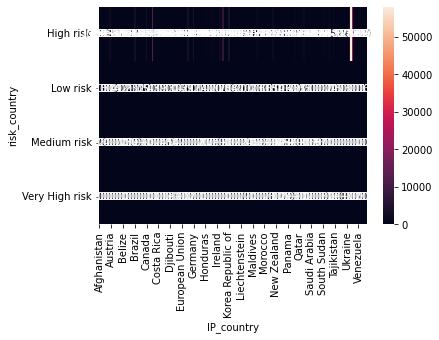

In [15]:
sns.heatmap(datasetCR, annot=True)

In [16]:
dataset.risk_country.unique()

array(['High risk', 'Very High risk', 'Medium risk', 'Low risk'],
      dtype=object)

In [17]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 453336.0


## Check for correlated variables with various numerical variables as dependent variable

In [18]:
model = ols('purchase_value ~ age_category + ip_address + seconds_since_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385890,0.235933
month_purchase,11.0,5.592780e+03,508.434589,1.514652,0.118319
weekday_purchase,6.0,3.353721e+03,558.953496,1.665151,0.125044
risk_country,3.0,7.147424e+02,238.247453,0.709751,0.546019
period_of_the_day,5.0,5.600741e+03,1120.148159,3.336978,0.005139
sex,1.0,1.926256e+02,192.625635,0.573841,0.448738
ip_address,1.0,5.010593e+00,5.010593,0.014927,0.902760
seconds_since_signup,1.0,2.002911e+01,20.029110,0.059668,0.807022
hour_of_the_day,1.0,4.724492e+01,47.244915,0.140745,0.707542
quick_purchase,1.0,1.000730e+03,1000.730053,2.981225,0.084238


In [19]:
model = ols('seconds_since_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.612254e+13,4.030634e+12,0.636547,6.363854e-01
month_purchase,11.0,5.186753e+17,4.715230e+16,7446.633220,0.000000e+00
weekday_purchase,6.0,3.827906e+13,6.379844e+12,1.007551,4.181384e-01
risk_country,3.0,6.529903e+12,2.176634e+12,0.343750,7.936911e-01
period_of_the_day,5.0,3.235919e+13,6.471838e+12,1.022080,4.025605e-01
sex,1.0,1.023447e+13,1.023447e+13,1.616301,2.036102e-01
ip_address,1.0,3.094208e+12,3.094208e+12,0.488660,4.845268e-01
purchase_value,1.0,3.783946e+11,3.783946e+11,0.059759,8.068779e-01
hour_of_the_day,1.0,6.905715e+12,6.905715e+12,1.090601,2.963398e-01
quick_purchase,1.0,1.473478e+15,1.473478e+15,232.702363,1.679680e-52


## XGBoost


In [20]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
numerical = dataset[['purchase_value', 'seconds_since_signup']] # Removed age

data = pd.concat([cat_encoded, numerical], axis = 1)



In [21]:
X = data
y = dataset[['class']]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [23]:
# Codes for upsampling

from sklearn.utils import resample
train_df = pd.concat([X_train, y_train], axis=1)
not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    95892
1    95892
Name: class, dtype: int64

In [24]:
X_train_upsampled = upsampled.iloc[:,:len(upsampled.columns)-1]
y_train_upsampled = upsampled.iloc[:,-1:]

In [25]:
upsampled.to_csv("final_train.csv")

# Concat test dataframe and output this to csv as well
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv("final_test.csv")

## Reading Final DataFrames, i.e. those that were upsampled

In [26]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


In [27]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

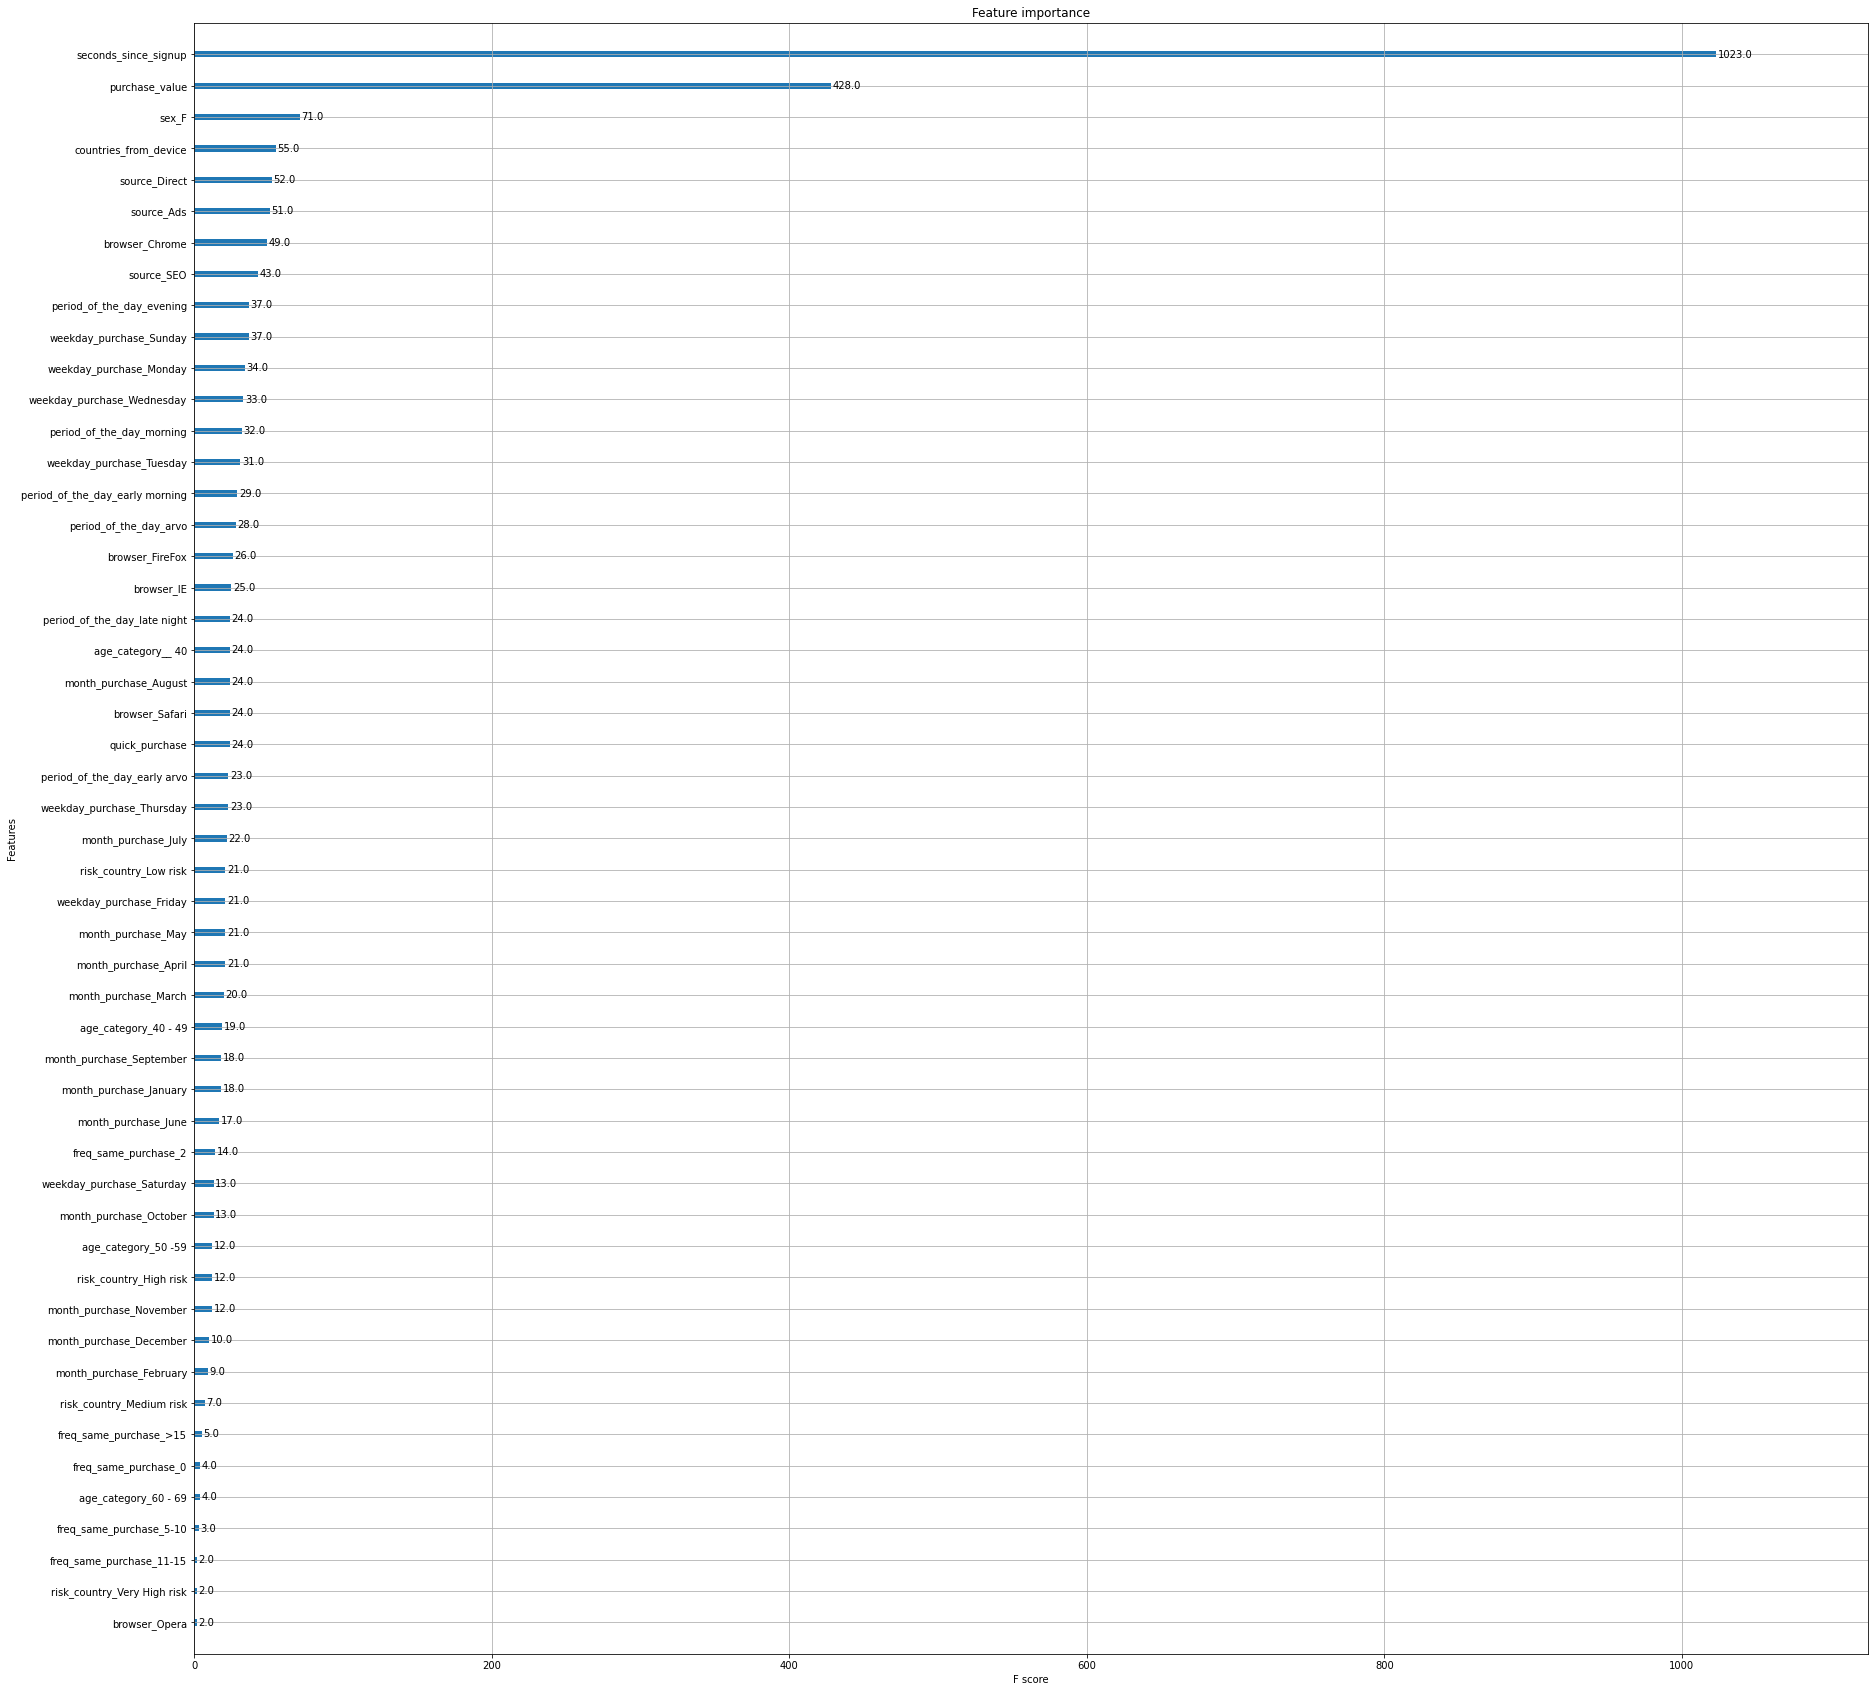

In [28]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

## RFE

In [29]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_

array([ 1, 43,  1, 20, 28,  1, 10,  1, 26,  1,  1,  7, 16, 22, 32, 23, 27,
        1,  4, 18, 14, 24, 21, 15, 12, 19,  3,  1,  5,  6, 11, 36, 38, 31,
       37, 41,  1, 25, 33, 13,  1,  8,  9,  2,  1, 17, 30, 29, 42, 40, 34,
       35, 39,  1,  1])

In [30]:
ranking = pd.DataFrame([1, 43, 18, 20, 23,  1,  2,  1, 25,  4,  1, 13,  5, 24, 36, 22, 31,
       12, 10, 17, 14, 27, 16,  7,  1, 19,  1,  9, 15,  3,  1, 32, 39, 37,
       35, 44, 21, 28, 40, 26,  1,  8, 11,  6,  1,  1, 29, 30, 42, 41, 33,
       34, 38,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category__ 40', 'period_of_the_day_arvo',
       'period_of_the_day_early arvo', 'period_of_the_day_early morning',
       'period_of_the_day_evening', 'period_of_the_day_late night',
       'period_of_the_day_morning', 'freq_same_purchase_0.0',
       'freq_same_purchase_2.0', 'freq_same_purchase_3.0',
       'freq_same_purchase_4.0', 'freq_same_purchase_11-15',
       'freq_same_purchase_5-10', 'freq_same_purchase_>15', 'purchase_value',
       'seconds_since_signup', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [31]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [32]:
rslt_df

,ranking,features
0,1,countries_from_device
5,1,browser_Chrome
7,1,browser_IE
10,1,sex_F
24,1,weekday_purchase_Friday
26,1,weekday_purchase_Saturday
30,1,weekday_purchase_Wednesday
40,1,period_of_the_day_arvo
44,1,period_of_the_day_late night
45,1,period_of_the_day_morning


## Select the relevant columns for building the model

Take from XGBoost section for Train Test Split, the codes now also have upsampled data

In [33]:
# final_df_X = data[['countries_from_device', 'source_Ads',
#       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
#       'weekday_purchase_Thursday', 'age_category_ > 70',
#       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
#       'age_category_< 40', 'period_of_the_day_arvo',
#        'purchase_value', 'seconds_since_signup']]

In [34]:
# final_df_y = dataset[['class']]

In [35]:
# X_train, X_test, y_train, y_test = train_test_split(
#    final_df_X, final_df_y, test_size=0.30, random_state=42)

In [36]:
# X_train

## Random Forest Classifer Before Upsampling

In [37]:
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc.fit(X_train, y_train)

rfc.decision_path(X_train)

C:\Users\J\AppData\Local\Temp\ipykernel_2504\1880976047.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


(<105778x1916310 sparse matrix of type '<class 'numpy.int64'>'
 	with 242658256 stored elements in Compressed Sparse Row format>,
 array([      0,   19283,   38452,   57219,   76336,   95789,  115046,
         134579,  153954,  173113,  192060,  211291,  230784,  249763,
         268842,  287697,  307338,  326607,  345406,  364711,  384290,
         403503,  422916,  442001,  461154,  480195,  498832,  517741,
         536424,  555811,  575140,  594201,  613620,  633071,  652014,
         670975,  690148,  709001,  728110,  747275,  766512,  785989,
         805502,  825147,  844226,  863251,  882704,  901907,  920760,
         939813,  959044,  978327,  997784, 1017029, 1036006, 1054651,
        1073690, 1092873, 1112272, 1131205, 1150276, 1169005, 1187992,
        1207415, 1226698, 1246687, 1265480, 1284391, 1303408, 1322479,
        1341456, 1360643, 1380402, 1400145, 1419164, 1437831, 1457306,
        1476343, 1495174, 1514345, 1533538, 1553157, 1572652, 1591729,
        1610986, 1

In [38]:
y_pred = rfc.predict(X_test)

from sklearn import metrics 

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- age_category_< 40
Feature names seen at fit time, yet now missing:
- age_category__ 40

  warnings.warn(message, FutureWarning)


ACCURACY OF THE MODEL:  0.9548903692592756


In [39]:
## Other metrics

print("precision score OF THE MODEL: ", metrics.precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", metrics.recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", metrics.f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred))

precision score OF THE MODEL:  0.9801038062283737
recall score OF THE MODEL:  0.5313012895662368
f1 score OF THE MODEL:  0.6890679641173788
ROC AUC score OF THE MODEL:  0.7650906116681169


## Random Forest Classifier After Upsampling

In [40]:
# rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

# rfc.fit(X_train_upsampled, y_train_upsampled)

# rfc.decision_path(X_train_upsampled)

In [41]:
# y_pred = rfc.predict(X_test)

# from sklearn import metrics 

# # using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
# print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
# print("precision score OF THE MODEL: ", metrics.precision_score(y_test, y_pred))
# print("recall score OF THE MODEL: ", metrics.recall_score(y_test, y_pred))
# print("f1 score OF THE MODEL: ", metrics.f1_score(y_test, y_pred))
# print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred))

## Logistic Regression

### Correlation Checking

In [42]:
cat_vars = [
    'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_Safari', 'sex_F', 'weekday_purchase_Thursday', 'age_category_ > 70', 
    'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69','age_category_< 40', 'period_of_the_day_arvo',
    ]
    
num_vars = ['countries_from_device', 'purchase_value', 'seconds_since_signup']

features_selected = ['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']

#### Chi Square Test (Categorical vs Catergorical)

In [43]:
p_values = []
chai_stats = []
for cat1 in cat_vars:
    for cat2 in cat_vars:
            crosstab = pd.crosstab(data[cat1], data[cat2])
            chai2, p_val, _, _ = chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))

chisquare = pd.DataFrame(p_values, columns=['Categorical 1', 'Categorical 2', 'p-value'])
chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')

Categorical 2,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,browser_Chrome,browser_Safari,period_of_the_day_arvo,sex_F,source_Ads,source_Direct,source_SEO,weekday_purchase_Thursday
Categorical 1,,,,,,,,,,,,,
age_category_ > 70,0.000000e+00,3.029295e-01,1.000000e+00,1.000000e+00,3.417567e-07,0.914181,1.000000,0.376163,1.000000,0.963895,0.164399,0.450235,0.454209
age_category_40 - 49,3.029295e-01,0.000000e+00,7.633076e-295,5.064812e-22,0.000000e+00,0.791410,0.815478,0.581859,0.202494,0.095534,0.384235,0.017138,0.308847
age_category_50 -59,1.000000e+00,7.633076e-295,0.000000e+00,1.648559e-04,0.000000e+00,0.274124,0.029245,0.316238,0.638514,0.048215,1.000000,0.048077,0.048300
age_category_60 - 69,1.000000e+00,5.064812e-22,1.648559e-04,0.000000e+00,1.275374e-293,0.408254,0.166818,0.741492,0.936471,0.183552,1.000000,0.185871,0.362758
age_category_< 40,3.417567e-07,0.000000e+00,0.000000e+00,1.275374e-293,0.000000e+00,0.391709,0.359618,0.895348,0.156141,0.406629,0.399899,0.127329,0.052721
browser_Chrome,9.141806e-01,7.914103e-01,2.741243e-01,4.082544e-01,3.917085e-01,0.000000,0.000000,0.437667,0.835759,0.715044,0.000276,0.008988,0.368526
browser_Safari,1.000000e+00,8.154776e-01,2.924522e-02,1.668185e-01,3.596182e-01,0.000000,0.000000,0.189722,0.523753,0.719170,0.046143,0.045368,0.023199
period_of_the_day_arvo,3.761631e-01,5.818588e-01,3.162380e-01,7.414920e-01,8.953479e-01,0.437667,0.189722,0.000000,0.549670,0.894604,0.106003,0.235483,0.087773
sex_F,1.000000e+00,2.024941e-01,6.385143e-01,9.364713e-01,1.561406e-01,0.835759,0.523753,0.549670,0.000000,0.938092,0.498873,0.523850,0.951839


Text(0.5, 1.0, 'Chi-Square Correlation Heatmap (Cat vs Cat)')

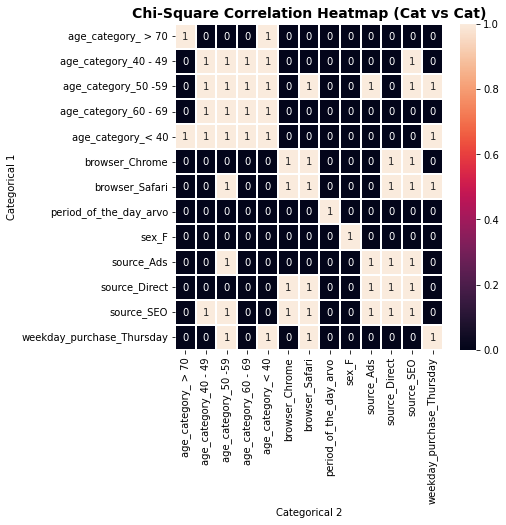

In [44]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

plt.title('Chi-Square Correlation Heatmap (Cat vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for chi square test, 1 indicating the rejection of null hypothesis, the categorical variables are correlated between one another.

#### Pearson Correlation (Numerical vs Numerical)

Text(0.5, 1.0, 'Pearson Correlation Heatmap (Num vs Num)')

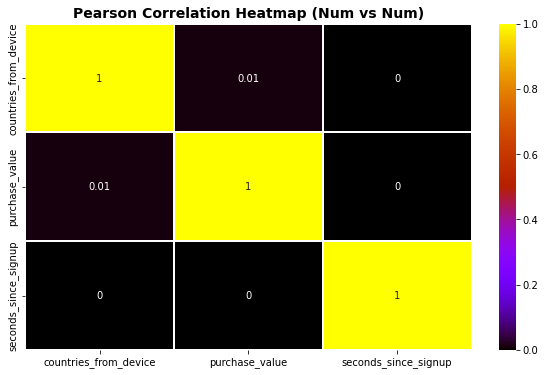

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
corrMatrix = dataset[num_vars].corr()
sns.heatmap(round(corrMatrix, 2), ax=ax,annot=True, cmap=cmap,linewidths=.05)

plt.title('Pearson Correlation Heatmap (Num vs Num)', fontsize=14, fontweight='bold')


From the correlation matrix, the numerical variables are not correlated to one another.

#### Anova Test (Numerical vs Categorical)

In [46]:
results = []

for cat in cat_vars:
    for num in num_vars:
        
        candidates = []
        for val in data[cat].unique():
            if len(data[data[cat]==val][num])>0:
                candidates.append(data[data[cat]==val][num])
                
        _, p_val = f_oneway(*candidates)
        results.append((cat, num, p_val))

In [47]:
anova = pd.DataFrame(results, columns=['Categorical', 'Numerical', 'P-value'])
anova.pivot_table(index='Numerical', columns='Categorical')

P-value                       \
Categorical           age_category_ > 70 age_category_40 - 49   
Numerical                                                       
countries_from_device           0.442735             0.549494   
purchase_value                  0.429586             0.031523   
seconds_since_signup            0.842212             0.556712   

                                                                \
Categorical           age_category_50 -59 age_category_60 - 69   
Numerical                                                        
countries_from_device            0.089754             0.936362   
purchase_value                   0.743723             0.826648   
seconds_since_signup             0.282725             0.639719   

                                                                       \
Categorical           age_category_< 40 browser_Chrome browser_Safari   
Numerical                                                               
countries_from_device          0.824131       0.844776       0.912697   
purchase_value                 0.034699       0.090500       0.427408   
seconds_since_signup           0.993261       0.000002       0.000319   

                                                                   \
Categorical           period_of_the_day_arvo     sex_F source_Ads   
Numerical                                                           
countries_from_device               0.452470  0.551148   0.053254   
purchase_value                      0.581404  0.437897   0.864608   
seconds_since_signup                0.012348  0.042767   0.276691   

                                                                          
Categorical           source_Direct source_SEO weekday_purchase_Thursday  
Numerical                                                                 
countries_from_device      0.281114   0.296028                  0.219103  
purchase_value             0.956089   0.900518                  0.032799  
seconds_since_signup       0.553557   0.116090                  0.090526

Text(0.5, 1.0, 'Anova Test Correlation Heatmap (Num vs Cat)')

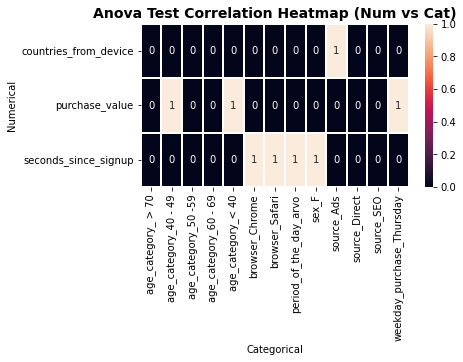

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2) <= 0.05,
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 annot=True, 
                 linewidths=.05)

plt.title('Anova Test Correlation Heatmap (Num vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for anova test, 1 indicating the rejection of null hypothesis, all the numerical variables are correlated with some of the categorical variables.

`In conclusion, we noticed correlation between the features that we have selected, which we will take account of in the further stages.`

### Running of Logistic Regression Model

#### Tuning Hyperparameter (Penalty [Regularisation], C value [Regularisation Rate]) through Cross-Validation

In [49]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l1', 'l2']
# define grid search
grid = dict(solver=solvers,penalty=penalty)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train_upsampled['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.839295 using {'penalty': 'l2', 'solver': 'saga'}
0.839295 with: {'penalty': 'l1', 'solver': 'saga'}
0.839295 with: {'penalty': 'l2', 'solver': 'saga'}


c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01,]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_scaled, y_train_upsampled['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.839295 using {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.839294 with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.839294 with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.839295 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.839295 with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.839273 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Actual Running of Model

In [15]:
# define models and parameters
model = LogisticRegression(solver='saga', penalty='l2', C=1)

# fit model
model.fit(X_train_scaled, y_train_upsampled['class'])

# predict model
y_pred = model.predict(X_test_scaled)


c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
# using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9236775929765739
precision score OF THE MODEL:  0.5805483289973984
recall score OF THE MODEL:  0.6801875732708089
f1 score OF THE MODEL:  0.6264305765493414
ROC AUC score OF THE MODEL:  0.814575756004028
